In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:01, 13266903.69it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 94364.81it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:01, 3980172.50it/s]                             
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


8192it [00:00, 32293.50it/s]            

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [4]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.603..  Test Loss: 0.452..  Test Accuracy: 0.835
Epoch: 2/30..  Training Loss: 0.477..  Test Loss: 0.443..  Test Accuracy: 0.844
Epoch: 3/30..  Training Loss: 0.449..  Test Loss: 0.402..  Test Accuracy: 0.855
Epoch: 4/30..  Training Loss: 0.439..  Test Loss: 0.419..  Test Accuracy: 0.850
Epoch: 5/30..  Training Loss: 0.425..  Test Loss: 0.411..  Test Accuracy: 0.855
Epoch: 6/30..  Training Loss: 0.407..  Test Loss: 0.385..  Test Accuracy: 0.861
Epoch: 7/30..  Training Loss: 0.400..  Test Loss: 0.396..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.402..  Test Loss: 0.392..  Test Accuracy: 0.864
Epoch: 9/30..  Training Loss: 0.393..  Test Loss: 0.401..  Test Accuracy: 0.859
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.387..  Test Accuracy: 0.863
Epoch: 11/30..  Training Loss: 0.390..  Test Loss: 0.391..  Test Accuracy: 0.862
Epoch: 12/30..  Training Loss: 0.387..  Test Loss: 0.381..  Test Accuracy: 0.866
Epoch: 13/30..  Training Loss: 0.373.

In [5]:
!wget -c https://raw.githubusercontent.com/shreyansh-tomar/Deep-Learning/master/Number%20Classification/helper.py?token=AELHHL5U5QVYDYEGBB6JQQK6CB7WO
import helper

--2019-12-28 12:07:10--  https://raw.githubusercontent.com/shreyansh-tomar/Deep-Learning/master/Number%20Classification/helper.py?token=AELHHL5U5QVYDYEGBB6JQQK6CB7WO
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py?token=AELHHL5U5QVYDYEGBB6JQQK6CB7WO’

helper.py?token=AEL 100%[===================>]   2.75K  --.-KB/s    in 0s      

2019-12-28 12:07:10 (51.8 MB/s) - ‘helper.py?token=AELHHL5U5QVYDYEGBB6JQQK6CB7WO’ saved [2813/2813]



In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

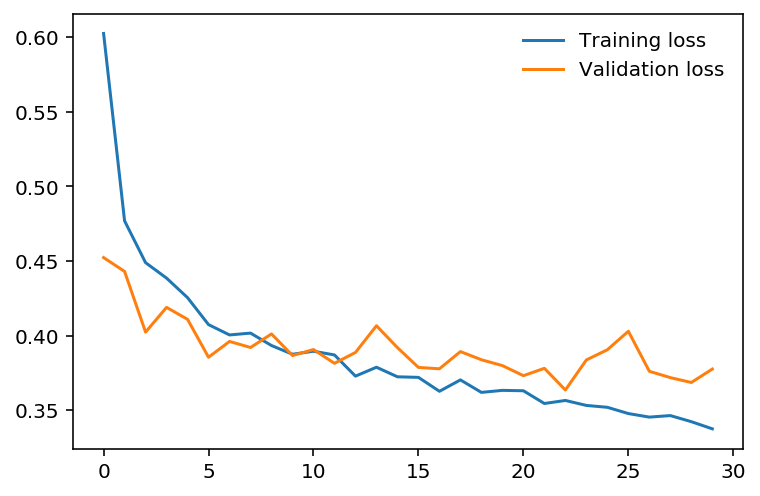

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)